In [2]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
#from algorithms import *
from distrib_algs import *
from utils import *
from tests import *
import importlib

%matplotlib inline

In [3]:
data_size = 6000

# Create the problem (for each value of num_of_workers run this code once)

In [3]:
# %%time
# dataset = "gisette"
# A, y, m, n, sparsity_A = prepare_data(dataset)
# print("Datasize: ", m, ", dimension: ", n)

In [4]:
# #%%time
# dataset = "gisette"
# num_of_workers = 20
# A, y, m, n, sparsity_A, data_split = prepare_data_distrib(dataset, data_size, num_of_workers)
# print("New datasize: ", m, ", dimension: ", n)
# L, average_L, worst_L = compute_L_distrib(dataset, A)
# denseA = A.toarray()
# print("Smoothness constant of f         : ", L)
# print("Average smoothness const of f_ij : ", average_L)
# print("Worst smoothness const of f_ij   : ", worst_L)
# print("Sparsity of A: ", sparsity_A)

In [5]:
# save_split(dataset, num_of_workers, data_split)

# Find the solution (run these cells only once!)

In [6]:
# %%time
# dataset = "gisette"
# A, y, m, n, sparsity_A = prepare_data(dataset)
# A = A[0:data_size]
# y = y[0:data_size]
# m, n = A.shape
# denseA = A.toarray()
# L, average_L, worst_L = compute_L_distrib(dataset, A)
# print("Datasize: ", m, ", dimension: ", n)
# print("Smoothness constant of f         : ", L)
# print("Average smoothness const of f_ij : ", average_L)
# print("Worst smoothness const of f_ij   : ", worst_L)

In [7]:
# filename=dataset+"_x_init_all_ones"
# x_init = np.ones(n)
# l2 = L/10000
# l1 = 0

In [8]:
# #%%time
# param = [A, y, l2, False, l1]
# res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
#                       method='L-BFGS-B',
#                       options={'maxiter':10000, 'disp':True}, tol=1e-30)

# print(res_solver.success)
# print(res_solver.fun)
# print(res_solver)

In [9]:
# save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Tests with 20 workers

In [4]:
#%%time
dataset = "gisette"
A, y, m, n, sparsity_A = prepare_data(dataset)
A = A[0:data_size]
y = y[0:data_size]
m, n = A.shape
denseA = A.toarray()
L, average_L, worst_L = compute_L_distrib(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

num_of_workers = 20
data_split = read_split(dataset, num_of_workers)
num_of_local_data = int(m/num_of_workers)
assert(num_of_local_data == len(data_split[0]))

Datasize:  6000 , dimension:  5000
Smoothness constant of f         :  842.8680386162022
Average smoothness const of f_ij :  1163.3450223356576
Worst smoothness const of f_ij   :  1201.509044847137


In [5]:
shift_param = 0.005
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = L/10000
l1 = 0
batch_size = 1
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)

sparse_full = False
sparse_stoch = False

In [6]:
print("f(x^0) = ", logreg_loss(x_init, [denseA,y,l2,False,0]))
print("f(x^*) = ", f_star)

f(x^0) =  8.154616014181194
f(x^*) =  0.13794947717298045


In [13]:
1.0/(L+l2)

0.001186306710170917

### Stochastic grad methods

In [16]:
%%time
S = 10
save_info_period = 10
gamma = 1.0/(L+l2)
sparsificator = identical
sparsificator_params = ["identical"]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 9min 39s, sys: 59.4 s, total: 10min 39s
Wall time: 3min 39s


In [6]:
%%time
S = 10
save_info_period = 10
gamma = 1.0/(L+l2)
sparsificator = topk
sparsificator_params = ["top-10", 10]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 7min 17s, sys: 5.09 s, total: 7min 22s
Wall time: 2min 29s


In [9]:
%%time
S = 10
save_info_period = 10
gamma = 1.0/(L+l2)
sparsificator = threshold
sparsificator_params = ["thr-200", 5e-3]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 9min 57s, sys: 56.6 s, total: 10min 53s
Wall time: 3min 39s


## Functional subomptimality vs Bits transmitted

Initial func_vals is: 8.01666653700821
Initial func_vals is: 8.01666653700821


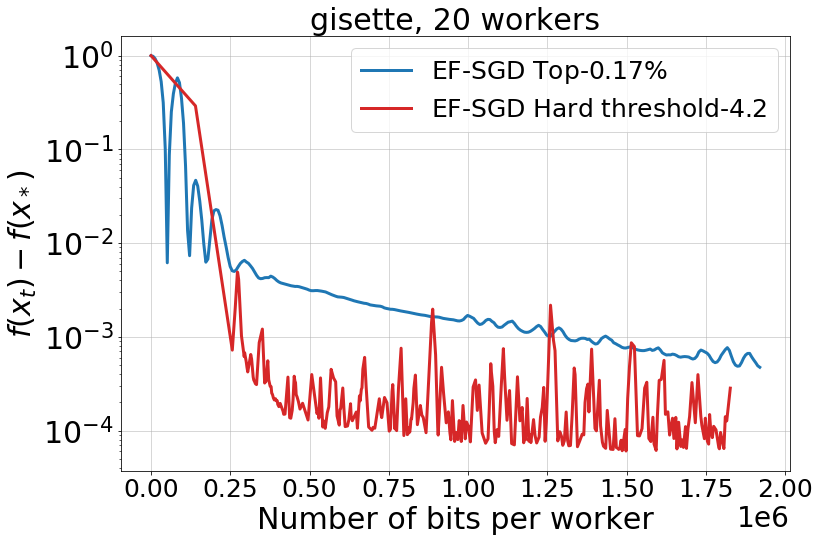

In [19]:
p = 1.0/num_of_local_data
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "top-10"], 
           'EF-SGD Top-$0.17\%$', None],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "thr-200"], 
           r'EF-SGD Hard threshold-$4.2$', None],
]
mode_y = 'func_vals'
mode_x = 'bits'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 25
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd_"+ dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

# Functional subotimality vs Epochs

Initial func_vals is: 8.01666653700821
Initial func_vals is: 8.01666653700821
Initial func_vals is: 8.01666653700821


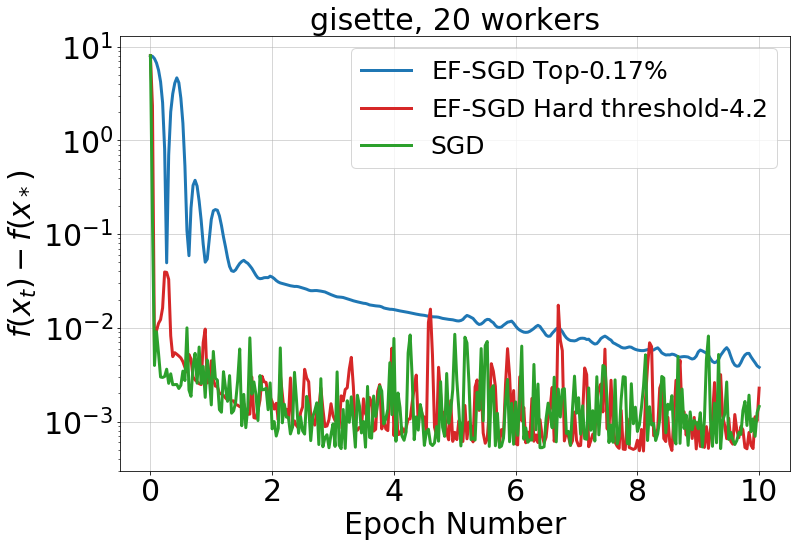

In [18]:
p = 1.0/num_of_local_data
methods = [
     ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "top-10"], 
           'EF-SGD Top-$0.17\%$', None],
   ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "thr-200"], 
           r'EF-SGD Hard threshold-$4.2$', None],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "identical"], 
           'SGD', None],
]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

# Bits vs iterations

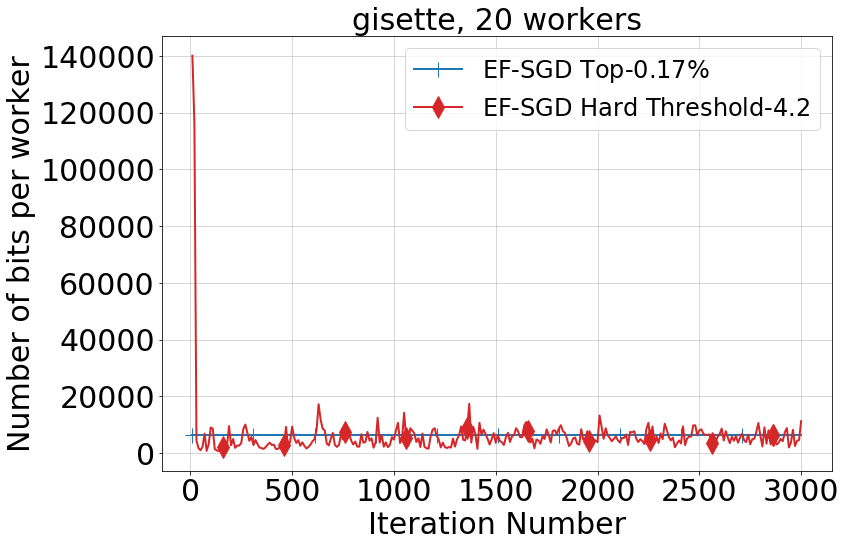

In [41]:
p = 1.0/num_of_local_data
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "top-10"], 
           'EF-SGD Top-$0.17\%$', None],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "thr-200"], 
           r'EF-SGD Hard Threshold-$4.2$', None],
]
mode_y = 'bits'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 24
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

# EC-grad norm vs iterations

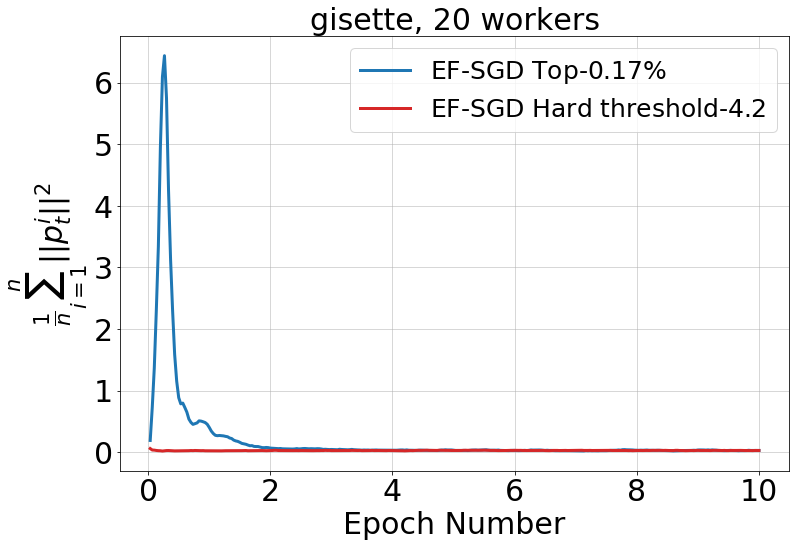

In [16]:
p = 1.0/num_of_local_data
methods = [
 ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "top-10"], 
           'EF-SGD Top-$0.17\%$', None],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "thr-200"], 
           r'EF-SGD Hard threshold-$4.2$', None],
]
mode_y = 'avg_ecgrad_norms'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

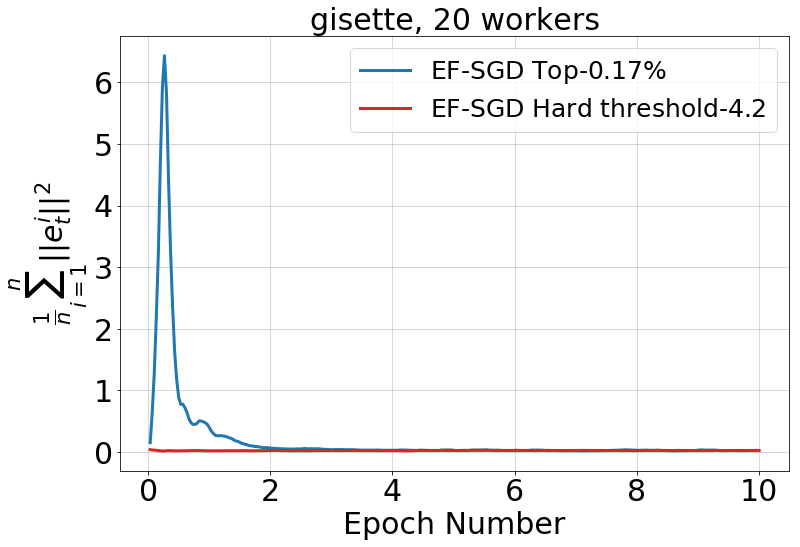

In [17]:
p = 1.0/num_of_local_data
methods = [
     ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "top-10"], 
           'EF-SGD Top-$0.17\%$', None],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 10, num_of_workers, "thr-200"], 
           r'EF-SGD Hard threshold-$4.2$', None],
]
mode_y = 'avg_error_norms'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)